In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn
from scikits.bootstrap import ci
import glob

# credit to http://people.duke.edu/~ccc14/pcfb/analysis.html
def bootstrap(data, num_samples, statistic, alpha=0.05):
    """Returns bootstrap estimate of 100.0*(1-alpha) CI for statistic."""
    n = len(data)
    idx = np.random.randint(0, n, (num_samples, n))
    samples = data[idx]
    stat = np.sort(statistic(samples, 1))
    return (stat[int((alpha/2.0)*num_samples)],
            stat[int((1-alpha/2.0)*num_samples)])


### Artist jump distributions

In [19]:
artist_jump_data = pd.read_table('../foragingAnalysis/MPA/jumpdists',header=None,names=['userid','vals'])
arr = np.array([[int(val) for val in row.split(',')] for row in artist_jump_data['vals']])
arrmean = arr/arr.sum(1,keepdims=True).astype(float)

In [21]:
arrmean.shape

(19079, 100)

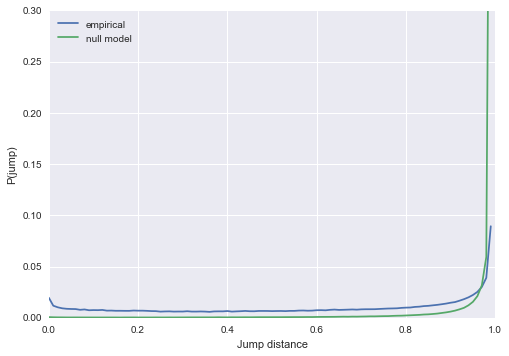

In [3]:
bins = np.arange(0,1.01,0.01)
fig,ax = plt.subplots(1,1)
randhops = np.load('../testData/1Mrandhops.npy')
ax.plot(bins[:-1],np.nanmean(arrmean,0),label='empirical')
ax.plot(bins[:-1],randhops,label='null model')
ax.set_xlabel('Jump distance')
ax.set_ylabel('P(jump)')
ax.set_ylim(0,0.3)
ax.legend(loc='upper left')

In [4]:
ci_lower = []
ci_upper = []
for i in xrange(arrmean.shape[1]):
    #lower,upper = ci(arrmean[:,i],statfunction=np.nanmean,n_samples=1000)
    lower,upper = bootstrap(arrmean[:,i],statistic=np.nanmean,num_samples=1000)
    ci_lower.append(lower)
    ci_upper.append(upper)

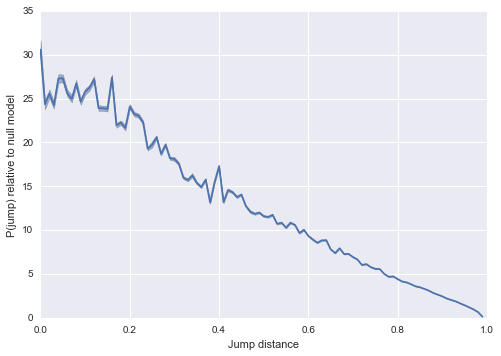

In [5]:
bins = np.arange(0,1.01,0.01)
fig,ax = plt.subplots(1,1)
ax.plot(bins[:-1],np.nanmean(arrmean,0)/randhops)
ax.fill_between(bins[:-1],np.array(ci_lower)/randhops,np.array(ci_upper)/randhops,alpha=0.5)
ax.set_xlabel('Jump distance')
ax.set_ylabel('P(jump) relative to null model')

### Patch segmentation parameter exploration

In [64]:
files = ['8957755','7591771']
for f in files:
    with open(f) as fin, open('temp{}'.format(f),'w') as fout:
        for line in fin:
            if 'simple' in line:
                line = line.split('\t')
                line.insert(3,'1')
                line = '\t'.join(line)+'\n'
            fout.write(line)
df= pd.concat([pd.read_table('temp{}'.format(f),header=None,names=['user','method','dist','mpl','d']) for f in files])



In [12]:
df = pd.read_table('../testData/patch_len_dists_concat',header=None,names=['user','method','dist','mpl','d'])

(0, 25)

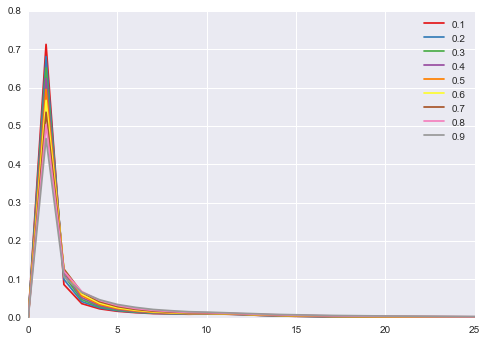

In [17]:
def grouper(df):
    result = np.zeros(1000)
    for d in df['d']:
        arr = np.array(d.split(','),dtype=int)
        arr =  arr/float(arr.sum())
        result += arr
    return result / len(df)

simple_means = df[df['method']=='simple'].groupby('dist').apply(grouper)
fig,ax = plt.subplots(1,1)
colors = seaborn.color_palette('Set1',n_colors=9)
for i,(dist,d) in enumerate(simple_means.iteritems()):
    ax.plot(d,label=dist,c=colors[i])
ax.legend()
ax.set_xlim(0,25)

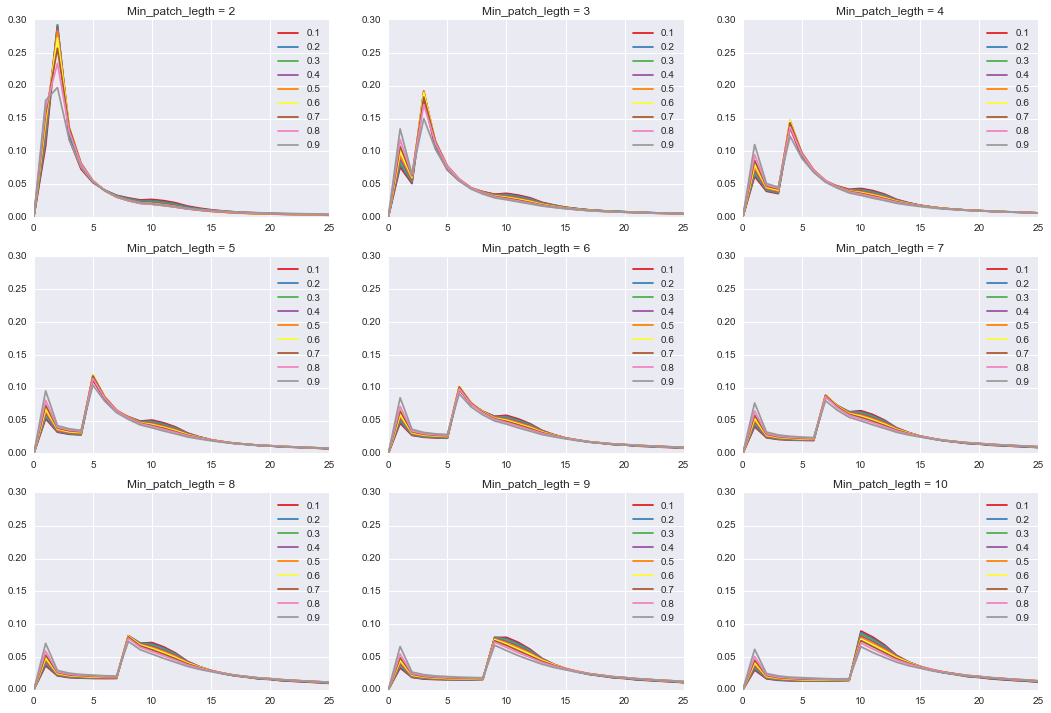

In [15]:
shuffle_means = df[df['method']=='shuffle'].groupby(['dist','mpl']).apply(grouper)
fig,axes = plt.subplots(3,3,figsize=(18,12))
ax_iter = axes.flat
colors = seaborn.color_palette('Set1',n_colors=9)
for grp in sorted(shuffle_means.index.levels[1]):
    ax = ax_iter.next()
    for i,(dist,d) in enumerate(shuffle_means.xs(grp,level='mpl').iteritems()):
        ax.plot(d,label=dist,c=colors[i])
    ax.legend()
    ax.set_title('Min_patch_legth = {}'.format(grp))
    ax.set_xlim(0,25)
    ax.set_ylim(0,0.3)

In [18]:
len(df['user'].unique())

2606